# DengAI: Predicting Disease Spread
A competition on DrivenData.org*
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/team/

![alt text](https://camo.githubusercontent.com/634d0493a085348b5a223df852e5cce5a0719c08/68747470733a2f2f64726976656e646174612e73332e616d617a6f6e6177732e636f6d2f696d616765732f64726976656e646174612e706e67) 
![alt text](https://miro.medium.com/max/6064/1*LcaaQR3BrsvMZT9QNcyRZg.jpeg)


**OBJECTIVE** 

Your goal is to predict the `total_cases` label for each `(city, year, weekofyear)` in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a `city` column indicating the source: `sj` for San Juan and `iq` for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as `NaN`s.



---


**FEATURES IN THE DATASET**

You are provided the following set of information on a (`year, weekofyear`) timescale:
(Where appropriate, units are provided as a `_unit` suffix on the feature name.)


***City and date indicators***
*   `city` – City abbreviations: sj for San Juan and iq for Iquitos
*   `week_start_date` – Date given in yyyy-mm-dd format

***NOAA's GHCN daily climate data weather station measurements***
•	station_max_temp_c – Maximum temperature

*   `station_min_temp_c` – Minimum temperature
*   `station_avg_temp_c` – Average temperature
*	  `station_precip_mm` – Total precipitation
*	  `station_diur_temp_rng_c` – Diurnal temperature range


***PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)***
*   `precipitation_amt_mm` – Total precipitation


***NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)***
*   `reanalysis_sat_precip_amt_mm` – Total precipitation
*   `reanalysis_dew_point_temp_k` – Mean dew point temperature
*   `reanalysis_air_temp_k` – Mean air temperature
*   `reanalysis_relative_humidity_percent` – Mean relative humidity
*   `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity
*   `reanalysis_precip_amt_kg_per_m2` – Total precipitation
*   `reanalysis_max_air_temp_k `– Maximum air temperature
*   `reanalysis_min_air_temp_k` – Minimum air temperature
*   `reanalysis_avg_temp_k` – Average air temperature
*   `reanalysis_tdtr_k` – Diurnal temperature range


***Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements***
*   `ndvi_se` – Pixel southeast of city centroid
*   `ndvi_sw` – Pixel southwest of city centroid
*   `ndvi_ne` – Pixel northeast of city centroid
*   `ndvi_nw` – Pixel northwest of city centroid

*Performance metric:* ***MAE***


**Useful Links:**
- EDA - Detailed Exploratory Data Analysis https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python
- TDS - Predicting Dengue Cases in Singapore
https://towardsdatascience.com/predicting-dengue-in-singapore-f9be0a761ce4

In [ ]:
! git push

Username for 'https://github.com/giuliamart/capstone_project_MLEN': 

In [ ]:
giulia.martielli@gmail.com

## Upload Files

Importing all needed libraries

In [109]:
!pip install -U -q PyDrive
!pip install regex
!pip install scikit-surprise
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gc
import regex as re
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

pd.options.display.max_rows = 200

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

### Training Data Features, Test Data Features, Training Data Labels

The features for the training dataset, the features for the testing dataset and the number of dengue cases for each row in the training dataset.

In [ ]:
df_train_gd = drive.CreateFile({'id':'1LVq5aLUiWdOoDYKVt3zbRHTjko7ioCRb'}) 
df_train_gd.GetContentFile('dengue_features_train.csv')
df_train = pd.read_csv('dengue_features_train.csv') 

df_test_gd = drive.CreateFile({'id':'10V_bmZSKvtukuBNJ317OY5K5fGCkSmaR'}) 
df_test_gd.GetContentFile('dengue_features_test.csv')
df_test = pd.read_csv('dengue_features_test.csv') 

dl_train_gd = drive.CreateFile({'id':'1oz-HCb7KoIU7awjnVJbO4pbJMGMwjj8V'}) 
dl_train_gd.GetContentFile('dengue_labels_train.csv')
dl_train = pd.read_csv('dengue_labels_train.csv',sep=';')

del df_train_gd, df_test_gd, dl_train_gd

In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [112]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
city                                     416 non-null object
year                                     416 non-null int64
weekofyear                               416 non-null int64
week_start_date                          416 non-null object
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2  

In [113]:
dl_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [ ]:
df_train=df_train.merge(dl_train,on=['city','year','weekofyear'],how='inner')

##EDA - Training Data Features (SJ)



###Numerical Variables

Precipitation variables' dstributions seem to be quite similar to the distribution of our target variable; might be correlated. Other variables look pretty "normal", with some outliers every now and then.

In [115]:
list(set(df_train_sj.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('<M8[ns]'), dtype('O')]

In [116]:
df_num = df_train_sj.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


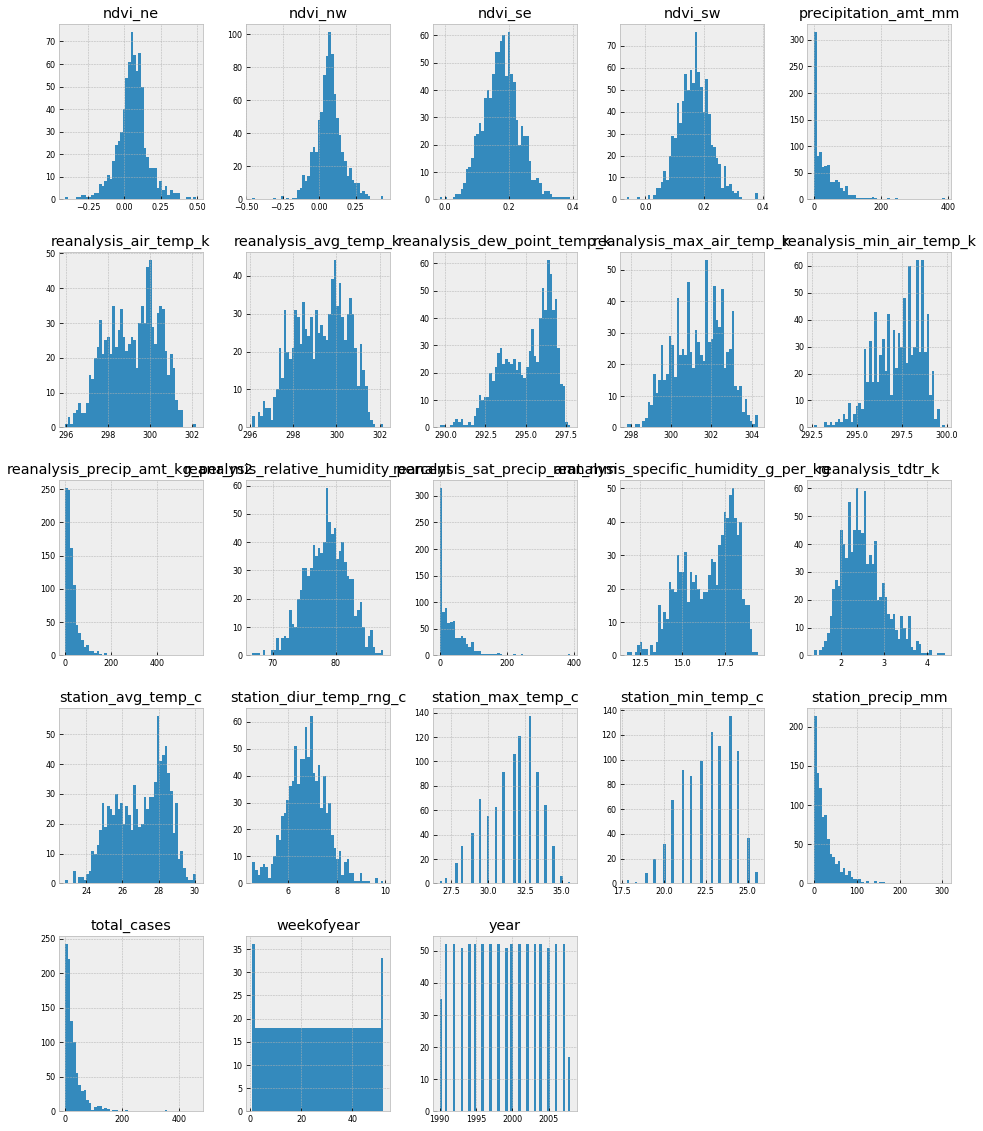

In [117]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

### Target Variable: Total Cases

With this information we can see that the total cases of dengue are skewed left and some outliers lies above ~100. We will eventually want to get rid of the them to get a normal distribution of the independent variable (`total_cases`) for machine learning.

Another option is the log transformation.

count    933.000000
mean      34.184352
std       51.451301
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64


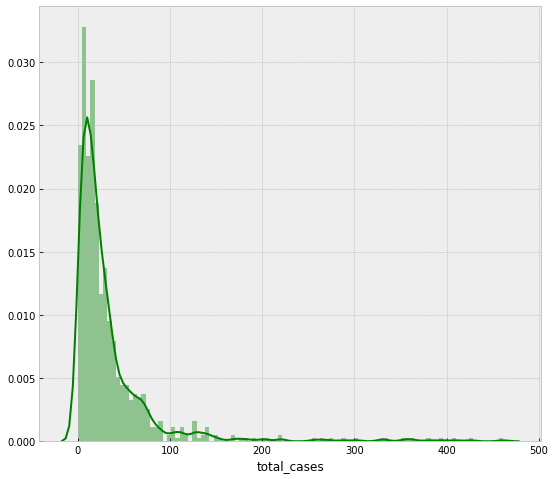

In [118]:
#Selecting one city --> San Juan
df_train_sj=df_train[df_train['city']=='sj']
print(df_train_sj['total_cases'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train_sj['total_cases'], color='g', bins=100, hist_kws={'alpha': 0.4});

###Target Variable: Correlation

Analyzing correlation with the target variable

In [119]:
df_num_corr = df_num.corr()['total_cases'][:-1] # -1 because the latest row is total_cases
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Cases:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with Total Cases:
Series([], Name: total_cases, dtype: float64)


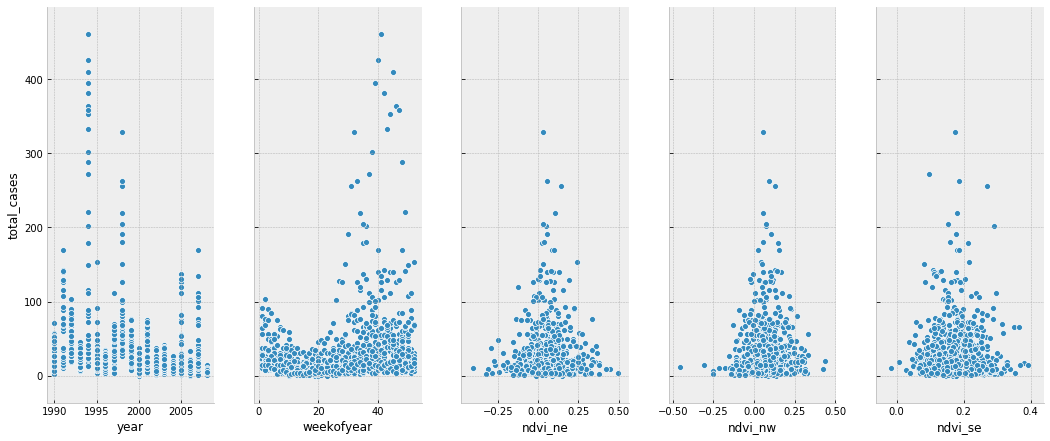

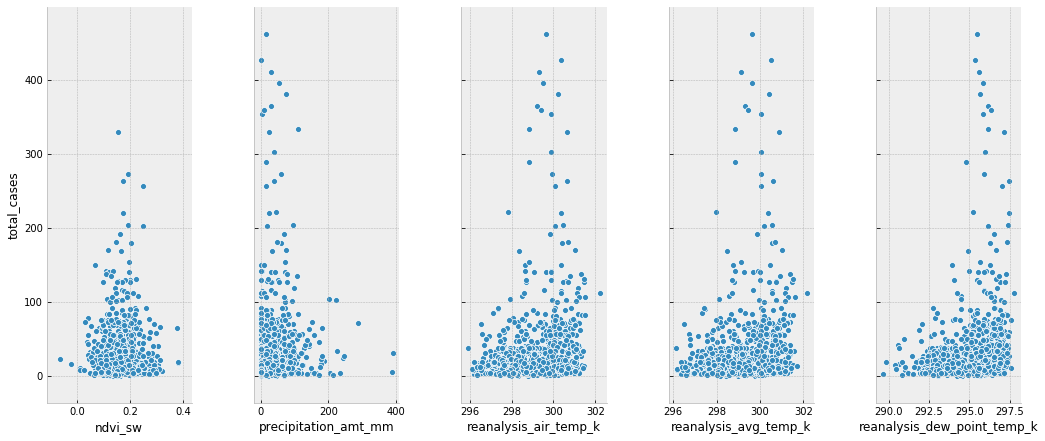

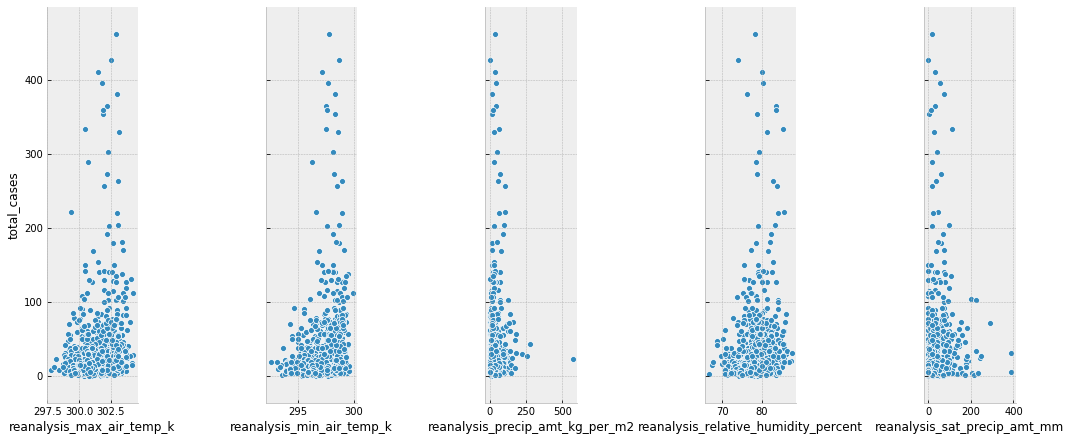

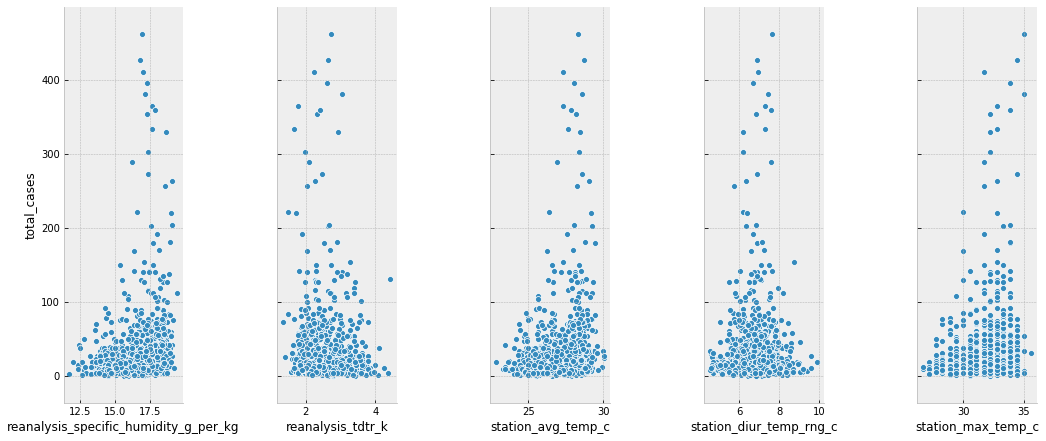

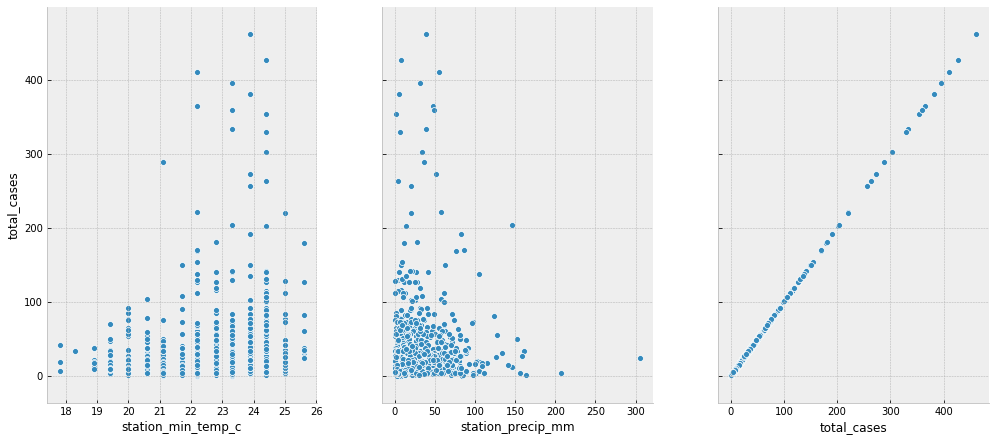

In [120]:
for i in range(0, len(df_num.columns), 5):
    g=sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['total_cases'])
    g.fig.set_size_inches(15,8)

In [121]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because the last column is SalePrice
    tmpDf = df_num[[df_num.columns[i], 'total_cases']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['total_cases'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

           year: -0.21256232895549873
reanalysis_tdtr_k: -0.06759992895244536
        ndvi_sw: -0.0003331922111150701
        ndvi_se: 0.001112776981849056
precipitation_amt_mm: 0.004091445734366524
reanalysis_sat_precip_amt_mm: 0.004091445734366524
station_diur_temp_rng_c: 0.03463006792870026
        ndvi_ne: 0.03763946284230521
station_precip_mm: 0.05027605315504646
        ndvi_nw: 0.07530714420074998
reanalysis_precip_amt_kg_per_m2: 0.10678786410910235
reanalysis_relative_humidity_percent: 0.14404469835447406
reanalysis_avg_temp_k: 0.17526745180821834
station_min_temp_c: 0.17701193575978025
reanalysis_air_temp_k: 0.18191694846733078
reanalysis_min_air_temp_k: 0.18794289083152557
station_max_temp_c: 0.1899007313998045
reanalysis_max_air_temp_k: 0.19453181561745608
station_avg_temp_c: 0.19661656049148904
reanalysis_dew_point_temp_k: 0.20377424158815935
reanalysis_specific_humidity_g_per_kg: 0.20794740781198076
     weekofyear: 0.2887852806751831


There is no evidence of strongly correlated variables to the target variable!

###Feature to Feature Relationship

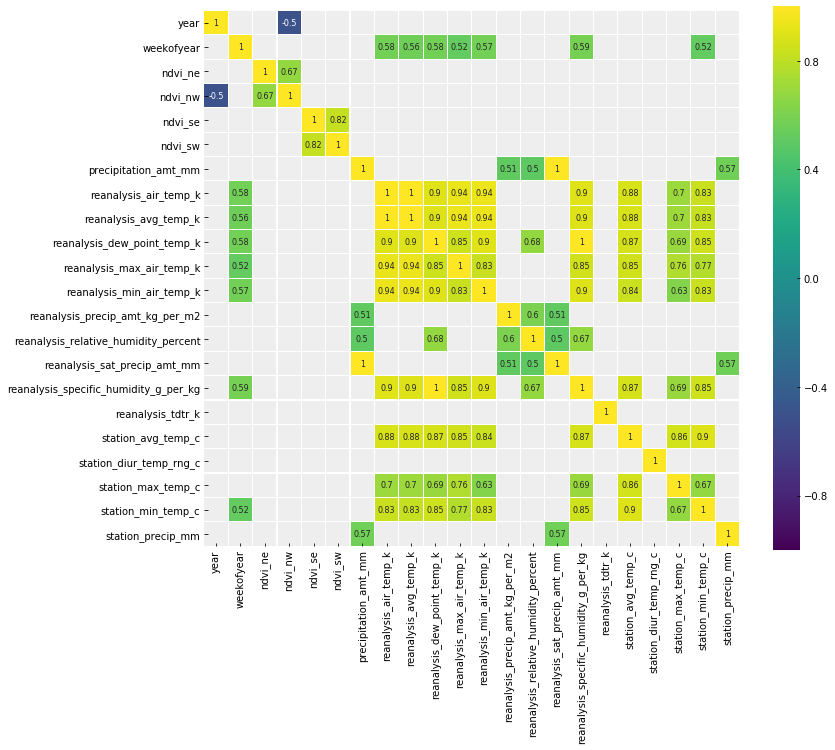

In [122]:
corr = df_num.drop('total_cases', axis=1).corr() # We already examined total_cases correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

- **Year-Vegetation** --> negatively correlated, as years go by, vegetation decreases
- **Week-Temperature** --> Clearly correated
- **Temperature-Humidity** --> Clearly correlated


Riprendo tutto il train di entrambe le città: 
Essendo San Juan nell'emisfero boreale e Iquitos nell'emisfero australe, le due città hanno comportamenti completamente opposti per quanto riguarda umidità e precipitazioni. 

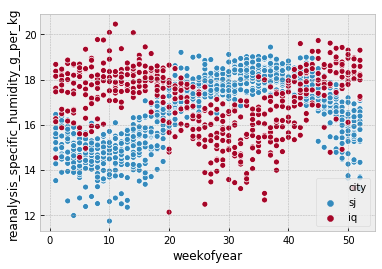

In [123]:
ax=sns.scatterplot(x="weekofyear", y="reanalysis_specific_humidity_g_per_kg",hue="city",data=df_train)

##Seasonality

In [124]:
df_train_sj["week_start_date"]=pd.to_datetime(df_train_sj["week_start_date"], format='%Y-%m-%d')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


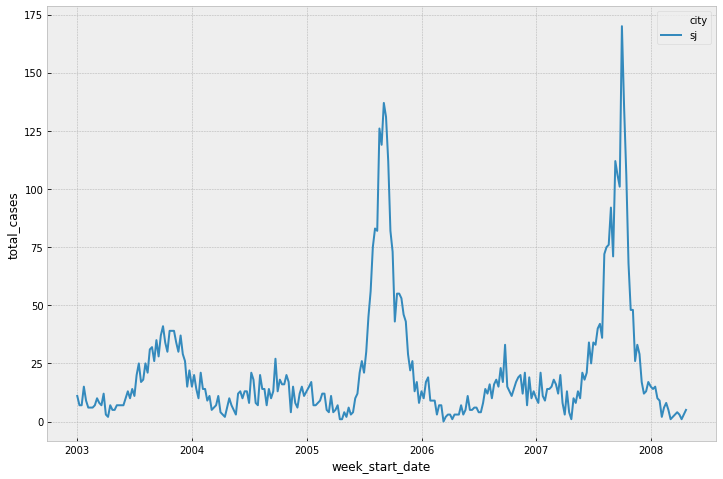

In [137]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x="week_start_date",y="total_cases", hue="city",ax=ax,data=df_train_sj[df_train_sj['year']>=2003])

In [127]:
df_train[df_train['year']>=2008]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
916,sj,2008,1,2008-01-01,0.000600,-0.309600,0.239814,0.195557,0.00,298.038571,298.121429,293.514286,299.9,296.6,27.99,76.148571,0.00,14.911429,1.842857,25.400000,5.300000,29.4,22.2,55.5,15
917,sj,2008,2,2008-01-08,NaN,-0.108250,0.330486,0.244286,37.24,298.142857,298.228571,293.595714,300.0,296.3,37.66,76.131429,37.24,14.980000,2.057143,24.971429,5.014286,28.3,21.1,64.8,14
918,sj,2008,3,2008-01-15,NaN,0.038300,0.125000,0.108843,0.00,297.627143,297.871429,293.020000,300.1,295.3,4.10,75.642857,0.00,14.488571,3.000000,24.428571,5.628571,27.8,20.6,2.5,15
919,sj,2008,4,2008-01-22,-0.026800,-0.215300,0.112614,0.160214,81.22,297.968571,298.128571,293.635714,299.5,296.4,27.16,77.167143,81.22,15.065714,2.000000,24.528571,4.585714,27.8,21.1,83.1,10
920,sj,2008,5,2008-01-29,NaN,-0.135400,0.223300,0.170943,0.00,298.021429,298.178571,292.957143,300.7,294.3,2.70,73.565714,0.00,14.408571,3.300000,24.571429,6.442857,28.9,20.0,3.1,9
921,sj,2008,6,2008-02-05,-0.111700,-0.003200,0.232843,0.271171,0.00,297.237143,297.278571,291.537143,299.3,295.4,19.70,70.642857,0.00,13.225714,2.071429,24.214286,5.157143,27.2,21.1,35.9,2
922,sj,2008,7,2008-02-12,0.072000,-0.063100,0.150200,0.149271,0.00,297.838571,297.907143,292.941429,299.3,296.5,10.17,74.228571,0.00,14.367143,2.157143,24.800000,6.242857,28.3,21.1,6.4,6
923,sj,2008,8,2008-02-19,-0.138650,-0.095067,0.246057,0.228129,0.00,297.907143,298.057143,293.134286,299.6,296.4,8.30,74.785714,0.00,14.538571,1.885714,24.900000,5.785714,28.3,21.7,13.3,8
924,sj,2008,9,2008-02-26,NaN,0.015420,0.211629,0.117343,0.00,297.765714,298.071429,292.502857,299.9,296.3,6.46,72.660000,0.00,13.967143,2.285714,24.742857,5.500000,27.8,21.1,12.9,5
925,sj,2008,10,2008-03-04,-0.088900,-0.090033,0.223243,0.154186,0.00,297.878571,298.007143,293.052857,299.9,295.5,6.50,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0,1
